In [19]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score,precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import random
import numpy as np
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

## Load dataset

In [2]:
# Section 1: Load the dataset paths and labels
import os

base_dir = 'FruQ-multi/'
all_images = []
all_labels = []
label_map = {}
image_counts = {}

for fruit in os.listdir(base_dir):
    fruit_path = os.path.join(base_dir, fruit)
    if os.path.isdir(fruit_path):
        for condition in os.listdir(fruit_path):
            condition_path = os.path.join(fruit_path, condition)
            if os.path.isdir(condition_path):
                label = f"{fruit}_{condition}"  # Combine fruit and condition
                if label not in label_map:
                    label_map[label] = len(label_map)  # Assign an index to each label
                image_counts[label] = image_counts.get(label, 0) + len([
                    img_file for img_file in os.listdir(condition_path)
                    if img_file.endswith('.jpg') or img_file.endswith('.png')
                ])
                for img_file in os.listdir(condition_path):
                    img_path = os.path.join(condition_path, img_file)
                    if img_path.endswith('.jpg') or img_path.endswith('.png'):
                        all_images.append(img_path)
                        all_labels.append(label_map[label])

for label, count in image_counts.items():
    print(f"Category '{label}' has {count} images.")

# Check total number of images and labels
total_images = sum(image_counts.values())
print(f"Total number of images: {total_images}")
print("Label map:", label_map)


Category 'BananaQ_Good' has 179 images.
Category 'BananaQ_Mild' has 96 images.
Category 'BananaQ_Rotten' has 337 images.
Category 'CucumberQ_Fresh' has 250 images.
Category 'CucumberQ_Mild' has 345 images.
Category 'CucumberQ_Rotten' has 116 images.
Category 'GrapeQ_Good' has 227 images.
Category 'GrapeQ_Mild' has 194 images.
Category 'GrapeQ_Rotten' has 288 images.
Category 'KakiQ_Good' has 545 images.
Category 'KakiQ_Mild' has 226 images.
Category 'KakiQ_Rotten' has 340 images.
Category 'PapayaQ_Good' has 130 images.
Category 'PapayaQ_Mild' has 250 images.
Category 'PapayaQ_Rotten' has 413 images.
Category 'PeachQ_Good' has 425 images.
Category 'PeachQ_Mild' has 136 images.
Category 'PeachQ_Rotten' has 584 images.
Category 'PearQ_Good' has 504 images.
Category 'PearQ_Mild' has 493 images.
Category 'PearQ_Rotten' has 100 images.
Category 'PepperQ_Good' has 48 images.
Category 'PepperQ_Mild' has 24 images.
Category 'PepperQ_Rotten' has 660 images.
Category 'StrawberryQ_Mild' has 119 im

## Split dataset 

In [3]:
train_split = 0.8
val_split = 0.1
test_split = 0.1

dataset_size = len(all_images)
train_size = int(train_split * dataset_size)
val_size = int(val_split * dataset_size)
test_size = dataset_size - train_size - val_size

print(f"Training size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

combined = list(zip(all_images, all_labels))
random.shuffle(combined)
all_images[:], all_labels[:] = zip(*combined)

# Now, create a TensorFlow dataset from the shuffled images and labels
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))

train_dataset = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

Training size: 7496
Validation size: 937
Test size: 937


## Augment data

In [4]:
batch_size = 32  # Define your batch size

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

# Augmentation function to apply to individual images
def augment(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)  
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    image = data_augmentation(image)
    return image, label


train_dataset = train_dataset.map(augment)
train_dataset = train_dataset.batch(batch_size)

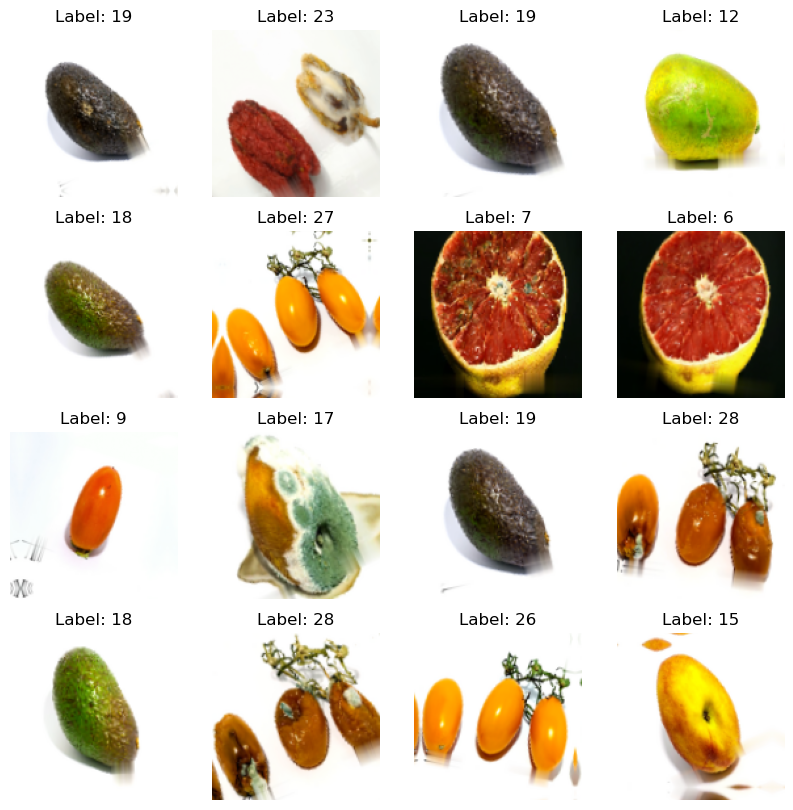

In [5]:
import matplotlib.pyplot as plt

# Function to display images in a grid
def display_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1): 
        for i in range(num_images):
            ax = plt.subplot(4, 4, i + 1)  
            plt.imshow(images[i].numpy())  
            plt.title(f"Label: {labels[i].numpy()}") 
            plt.axis("off")  
    plt.show()

display_images(train_dataset, 16)


## Process and batch dataset

In [6]:
image_size = (128, 128)
batch_size = 32

def process_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)  
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, image_size) 
    image = image / 255.0 
    return image, label

# Apply processing directly to datasets
val_dataset = val_dataset.map(process_image)
test_dataset = test_dataset.map(process_image)

# Batch the datasets
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## Train model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_map), activation='softmax')  
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Include early_stopping in the callbacks when fitting the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping],
    shuffle = False
)

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

Epoch 1/10
235/235 [==============================] - 125s 531ms/step - loss: 1.0963 - accuracy: 0.7724 - val_loss: 0.2200 - val_accuracy: 0.9253
Epoch 2/10
235/235 [==============================] - 226s 965ms/step - loss: 0.1785 - accuracy: 0.9361 - val_loss: 0.1368 - val_accuracy: 0.9552
Epoch 3/10
235/235 [==============================] - 192s 815ms/step - loss: 0.1498 - accuracy: 0.9468 - val_loss: 0.0838 - val_accuracy: 0.9701
Epoch 4/10
235/235 [==============================] - 219s 933ms/step - loss: 0.1056 - accuracy: 0.9605 - val_loss: 0.1237 - val_accuracy: 0.9648
Epoch 5/10
235/235 [==============================] - 117s 499ms/step - loss: 0.0902 - accuracy: 0.9656 - val_loss: 0.0599 - val_accuracy: 0.9744
Epoch 6/10
235/235 [==============================] - 146s 623ms/step - loss: 0.0897 - accuracy: 0.9660 - val_loss: 0.1046 - val_accuracy: 0.9594
Epoch 7/10
235/235 [==============================] - 219s 928ms/step - loss: 0.0836 - accuracy: 0.9686 - val_loss: 0.0763 -

## Visualisations

In [ ]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 33ms/step
Overall Precision: 0.9402
Overall Recall: 0.9229
Overall F1 Score: 0.9239
Overall Accuracy Score: 0.9797
Unique values in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Unique values in y_pred: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31]
Classification Report:
                     precision    recall  f1-score   support

      BananaQ_Good     0.9643    1.0000    0.9818        27
      BananaQ_Mild     1.0000    0.8571    0.9231         7
    BananaQ_Rotten     1.0000    1.0000    1.0000        30
   CucumberQ_Fresh     1.0000    1.0000    1.0000        25
    CucumberQ_Mild     1.0000    1.0000    1.0000        32
  CucumberQ_Rotten     1.0000    1.0000    1.0000        12
       GrapeQ_Good     1.0000    1.0000    1.0000        18
       GrapeQ_Mild     1.0000    0.9286    0.9630        14
     GrapeQ_Rotten     0.9524    

c:\Users\there\miniconda3\envs\cnn_project_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\there\miniconda3\envs\cnn_project_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\there\miniconda3\envs\cnn_project_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

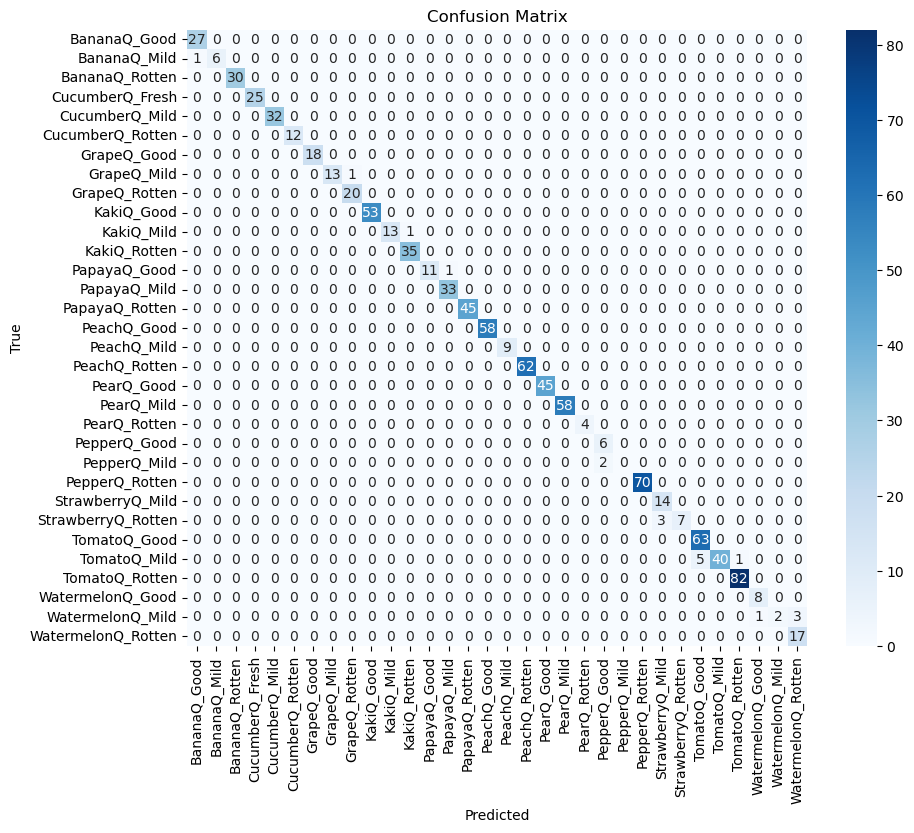

In [20]:
y_true = []
y_pred = []
actual_images = []  

# Step 1: Get predictions and true labels
for images, labels in test_dataset:  
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Append true labels, predicted labels, and images
    y_true.extend(labels.numpy().astype(int))  
    y_pred.extend(predicted_labels.astype(int))  
    actual_images.extend(images.numpy()) 

overall_precision = precision_score(y_true, y_pred, average='macro')
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1 = f1_score(y_true, y_pred, average='macro')
overall_average = accuracy_score(y_true, y_pred)

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1 Score: {overall_f1:.4f}")

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=list(label_map.keys()), digits=4)
print("Classification Report:\n", report)

# Step 3: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

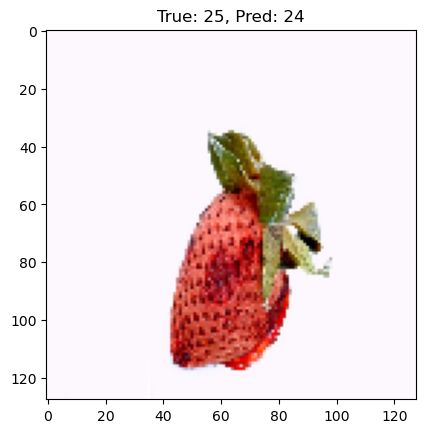

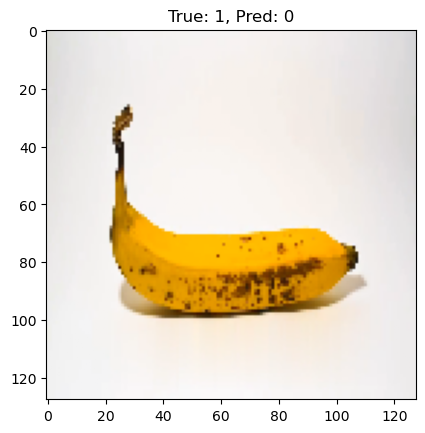

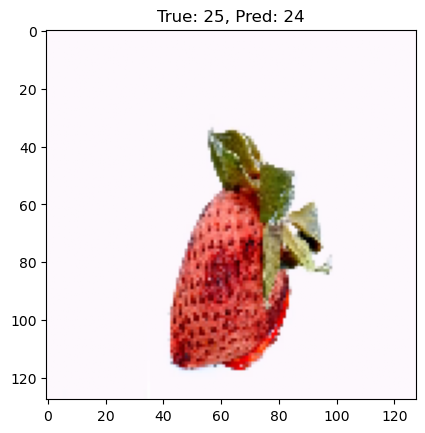

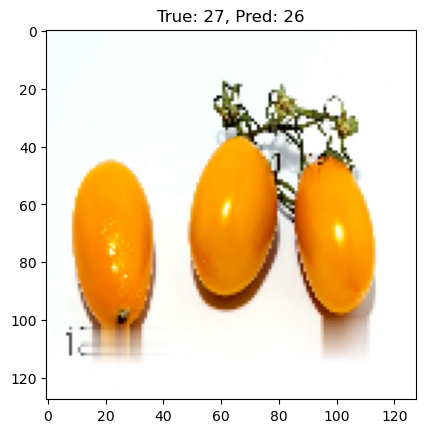

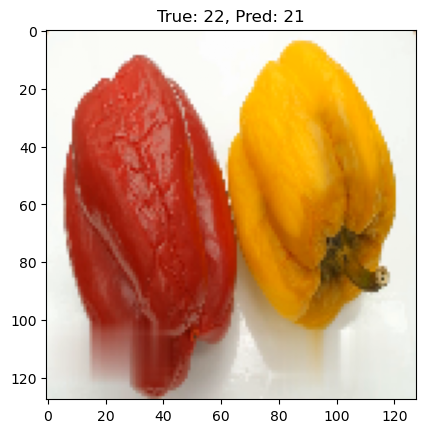

In [22]:
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

for i in range(5):  # Visualize the first 5 misclassified images
    idx = misclassified_indices[i]
    img = actual_images[idx]  
    
    plt.imshow(img) 
    plt.title(f'True: {y_true[idx]}, Pred: {y_pred[idx]}')
    plt.show()

## Test new images

1/1 [==============================] - 0s 18ms/step


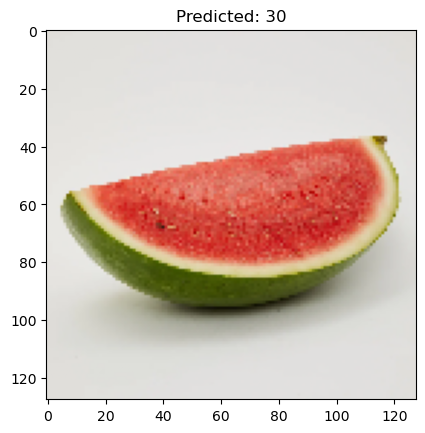

In [24]:
def preprocess_image(image_path, image_size=(128, 128)):
    img = tf.io.read_file(image_path)          
    img = tf.io.decode_png(img, channels=3)    
    img = tf.image.resize(img, image_size)     
    img = img / 255.0                          
    img = tf.expand_dims(img, 0)               
    return img

def predict_image(image_path, model):
    img = preprocess_image(image_path)  
    predictions = model.predict(img)   
    predicted_label = np.argmax(predictions, axis=1)[0] 
    return predicted_label 

image_path = 'test2.png'

predicted_label = predict_image(image_path, model)

img = preprocess_image(image_path)[0] 
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.show()

